In [483]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import numpy as np
import re
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Code"></form>''')

# Reentry Chile Response Rate

*Sebastian Daza*

In this report I describe response rates by wave. I follow these general criteria:

- The estimation by wave only uses cases far beyond the wave-specific observation window. For instance, for the wave 2-months, we only consider those women who have been in the study for 4 months.
- This estimation is based on the administrative records of the study.

Some important definitions:

- Names of waves: baseline, week, two_months six_months
- Variables names: `d` means date, `c` means clean, and `cd` clean date
- Deadline corresponds to th time threshold to compute a given response rate

I review the key date variables to compute the rates and highlight inconsistencies or problems. 

## Release

There are two date of release variables
in the register data. *Definitive* has a bunch of missing records. **We should define a validated and unique date of release variable**. 

In [484]:
import os
import pandas as pd
import re 

path = '/Users/sdaza/Desktop/seguimiento/'
files = os.listdir(path)
files

['.DS_Store',
 'formulario de seguimiento - javiera 30.xlsx',
 'Formulario de Seguimiento - Marisol.xlsx',
 'Formulario de Seguimiento - Pati.xlsx',
 'Formulario de Seguimiento - Susana 40.xlsx',
 'formulario de seguimiento marce.xlsx',
 '~$formulario de seguimiento - javiera 30.xlsx',
 '~$formulario de seguimiento marce (1).xlsx']

In [485]:
# exclude temp files and DS_Store
cfiles = [re.findall(r'^[a-zA-Z].+', file) for file in files]
cfiles = list(filter(None, cfiles))
cfiles

[['formulario de seguimiento - javiera 30.xlsx'],
 ['Formulario de Seguimiento - Marisol.xlsx'],
 ['Formulario de Seguimiento - Pati.xlsx'],
 ['Formulario de Seguimiento - Susana 40.xlsx'],
 ['formulario de seguimiento marce.xlsx']]

In [486]:
# read data
df = pd.DataFrame()
for file in cfiles:
    if file: 
        t = pd.read_excel(path+file[0], skiprows=[0,1])
        t.rename(columns=lambda x: x.strip(), inplace=True) # remove spaces
        df = df.append(t, ignore_index=True)

In [487]:
# extract columns
cols = ['enc','folio','fegresoefectiva', 'lb_fechaentrevista', 'lb_participa', 
       'primsem_fechaentrevista', 'primsem_participa', 'dosmeses_fechaentrevista', 
        'dosmeses_participa', 'seismeses_fechaentrevista', 'seismeses_participa', 
       'docemeses_fechaentrevista', 'docemeses_participa']

df = df.loc[:,cols]
df.shape

(229, 13)

In [488]:
# rename columns
names = ["int","id", "release_f","dbaseline","r_baseline",
         "dweek","r_week","d2months","r_2months",
         "d6months","r_6months","d12months","r_12months"]

df.rename(columns=dict(zip(cols, names)), inplace=True)

null = df.int.notnull()
df = df.loc[null, names]

# remove case
df = df.loc[df.id != 10011,:]
df.shape

(225, 13)

In [489]:
# save data

import dill

dill.dump(df, open('registro.pkl', 'wb'))

# load the data
df = dill.load(open('registro.pkl', 'rb'))

In [490]:
# no valid records for release_f?
s = df.release_f.isnull()
s.value_counts()

False    225
Name: release_f, dtype: int64

In [491]:
#df.loc[s, 'release'] = df.loc[s, 'release_o']

In [492]:
# start = pd.to_datetime("09/01/2016")
# s = (df.release < start) & (df.release_o >= start)
# df.loc[s, ['release']] = df.loc[s, ['release_o']]
df['release_year'] = pd.DatetimeIndex(df['release_f']).year
df['release_month'] = pd.DatetimeIndex(df['release_f']).month

# year and months
print(df.release_year.value_counts())
print(df.release_month.value_counts())

2016    147
2017     78
Name: release_year, dtype: int64
10    72
12    34
3     30
11    28
1     28
2     20
9     13
Name: release_month, dtype: int64


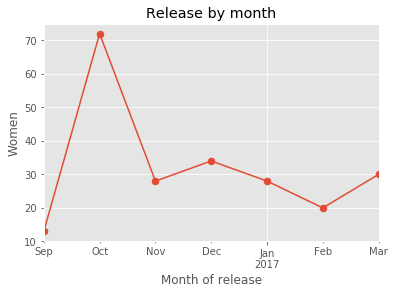

In [493]:
# release plot

t = df.reset_index().set_index('release_f')
t = t.resample('M')
ax = t.id.count().plot(title='Release by month', style='.-', ms=13);
ax.set_ylabel("Women");
ax.set_xlabel("Month of release");

## Baseline

Let's explore the baseline information. 

Below a plot with the distribution of the difference between the date of the baseline and release. All values should be negative. 

To check cases below where we have issues: missing data or positive value (i.e., the baseline was applied after release). 

In [494]:
# baseline response
# varname = [col for col in df.columns if 'sí: se realizó línea base' in col]
#print(varname)
# df = df.rename(columns={'lb_response': 'r_baseline'})
# df
# df.r_baseline.value_counts()
# df['r_baseline'] = df['r_baseline'].str.contains("s|S")

Case 20112 has a problem with baseline date of interview. 

In [495]:
# correct some dates

df[df.dbaseline.isnull()]
df.loc[df.id == 20112, 'dbaseline'] = '2016-10-19'

In [496]:
# function to clean dates
import re

def clean_dates(text):
   if (isinstance(text, str)):
      text = str(text)
      pp = re.compile("-|\.")
      r = re.sub(pp, "/", text)
      pp = re.compile("([0-9]+/[0-9]+/[0-9]+)|([0-9]+-[0-9]+-[0-9]+)")
      r = re.search(pp, r)
      if (r is not None):
         r = r.group()
      else:
         r = ''
   else:
      r = text
   return pd.to_datetime(r, dayfirst=True, errors = 'coerce')

In [497]:
df['cdbaseline'] = [clean_dates(i) for i in df['dbaseline']]

In [498]:
# m = df['cdbaseline'].isnull() & df['dbaseline'].notnull()
# df.loc[m, ['int', 'id', 'cdbaseline', 'dbaseline']]

In [499]:
# replace errors in data entry
# errors = ['V16/12716', 'V14 y M18/10']
# new_values = ['12/16/16', '10/18/16']
# 
# for i in range(0,len(errors)):
#    df.loc[df['dbaseline'] == errors[i], 'cdbaseline'] = pd.to_datetime(new_values[i])

In [500]:
# identify inconsistent cases
# df.release_baseline.describe()
# ax = df.release_baseline.hist(bins = 40);
# ax.set_xlabel('Baseline date - Release');

Some problems in the rows and dates below. Look at last Marcela row. 

In [501]:
df = df.assign(release_baseline = (df.cdbaseline - df.release_f).dt.days)
s = ((df.release_baseline > 0) | (df.cdbaseline.isnull()))
df.loc[s, ['int', 'id', 'r_baseline', 'release_f',  'cdbaseline', 'dbaseline', 'release_baseline']].sort_values('id')

,int,id,r_baseline,release_f,cdbaseline,dbaseline,release_baseline
0,Javi,10007.0,Sí,2016-09-20,2016-12-09,2016-12-09 00:00:00,80.0
74,Marisol,10291.0,Sí,2017-03-22,NaT,NaT,NaN
201,Marcela,50037.0,SI,2016-10-19,2017-09-30,2017-09-30 00:00:00,346.0
204,Marcela,50060.0,17:00:00,2016-10-19,NaT,NaT,NaN


Descriptives of the difference between release date and baseline: 

In [502]:
df.release_baseline.describe()

count    223.000000
mean     -12.295964
std       39.939733
min     -367.000000
25%      -14.000000
50%       -7.000000
75%       -4.000000
max      346.000000
Name: release_baseline, dtype: float64

## First week


Below a plot with the distribution of the difference between the date of the first week interview and release. All values should be **positive**. 


In [503]:
# varname = [col for col in df.columns if 'participa' in col]
# print(varname)

In [504]:
# df = df.rename(columns={varname[1]: 'r_week'})
#df.r_week.value_counts()
df['r_week'] = df['r_week'].str.contains("s|S").astype(float)
df['r_week'] = df.r_week.fillna(0)
#df.r_week.isnull().value_counts()
df.r_week.value_counts()

1.0    182
0.0     43
Name: r_week, dtype: int64

In [505]:
# varname = [col for col in df.columns if 'fecha' in col]
#print(varname)

In [506]:
# varname = [col for col in df.columns if 'fecha entrevista' in col]
#print(varname)

In [507]:
# df = df.rename(columns={varname[0]: 'dweek'})

In [508]:
df['cdweek'] = [clean_dates(i) for i in df['dweek']]
#df.cdweek.describe()

In [509]:
m = df.cdweek.isnull() & df.dweek.notnull()
# df.loc[m, ['id', 'cdweek', 'dweek']]

In [510]:
# # replace errors in data entry
# errors = ['S29/10 y W02/11']
# new_values = ['11/02/2016']

# for i in range(0,len(errors)):
#    df.loc[df['dweek'] == errors[i], 'cdweek'] = pd.to_datetime(new_values[i])

# s = (df.r_week == 1)
# #df.loc[s, 'cdweek'].isnull().value_counts()

In [511]:
df = df.assign(release_week = (df.cdweek - df.release_f).dt.days)
(df.release_week > 7).value_counts()

True     157
False     68
Name: release_week, dtype: int64

Plot of the difference between date of release and first week interview.

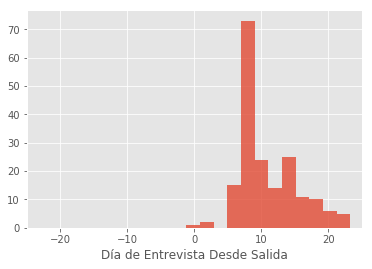

In [512]:
ax = df.release_week.hist(bins = 300, alpha = 0.8);
ax.set_xlim(-25,25)
ax.set_xlabel('Día de Entrevista Desde Salida');

In [513]:
df['week_deadline'] = pd.DatetimeIndex( df['release_f'] ) + pd.DateOffset(weeks = 5) # five weeks!

Cases with issues: 

In [514]:
import datetime
today = datetime.datetime.now()
s = ((df.r_week == 1) & (today > df.week_deadline)) & ( (df.release_week <= 0) | (df.cdweek.isnull()) )

df.loc[s,['int', 'id', 'r_week', 'release_f', 'cdweek', 'release_week']].sort_values('id')

,int,id,r_week,release_f,cdweek,release_week


In [515]:
df.loc[np.abs(df.release_week) > 30,['int', 'id', 'r_week', 'release_f', 'cdweek', 'release_week']]

,int,id,r_week,release_f,cdweek,release_week
68,Pati,20142.0,1.0,2016-11-16,2017-11-23,372.0
80,Pati,10015.0,0.0,2016-09-25,2016-02-10,-228.0
101,Pati,20071.0,1.0,2016-10-20,2017-10-27,372.0
105,Pati,20112.0,0.0,2016-10-19,2017-10-26,372.0
116,Pati,20200.0,1.0,2016-12-31,2017-02-27,58.0
163,Susana,10053.0,1.0,2016-10-19,2016-11-25,37.0
211,Marcela,50126.0,1.0,2016-12-07,2017-12-21,379.0
215,Marcela,50163.0,1.0,2016-11-26,2017-12-12,381.0
216,Marcela,50180.0,1.0,2016-12-07,2017-12-27,385.0


Response rate:

In [516]:
tab  = df.loc[ (today > df.week_deadline) | (df.r_week == 1), 'r_week'].value_counts()
rr_week = [i / sum(list(tab)) for i in tab][0]
print(rr_week)

0.808888888889


Descriptives of the difference between date of release and interview first week. 

In [517]:
df.loc[df.r_week == 1, 'release_week'].describe()

count    182.000000
mean      21.489011
std       60.355186
min        1.000000
25%        8.000000
50%       10.000000
75%       14.000000
max      385.000000
Name: release_week, dtype: float64


# Two Months
 

In [518]:
# varname = [col for col in df.columns if 'participa ' in col]
#print(varname)

In [519]:
# df = df.rename(columns={varname[0]: 'r_2months'})
#df.r_2months.value_counts()
df['r_2months'] = df['r_2months'].str.contains("s|S").astype(float)
df['r_2months'] = df.r_2months.fillna(0)
#df.r_2months.isnull().value_counts()
#df.r_2months.value_counts()

In [520]:
# date 2months
# varname = [col for col in df.columns if 'fecha entrevista' in col]
#print(varname)

In [521]:
# df = df.rename(columns={varname[0]: 'd2months'})

In [522]:
df['cd2months'] = [clean_dates(i) for i in df['d2months']]

Some cases with issues:

In [523]:
m = df.cd2months.isnull() & df.d2months.notnull()
df.loc[m, ['id', 'release', 'cd2months', 'd2months']]

,id,release,cd2months,d2months
72,50190.0,NaN,NaT,27/2


In [524]:
# replace errors in data entry
errors = ['27/2']
new_values = ['02/27/2017']

for i in range(0,len(errors)):
   df.loc[df['d2months'] == errors[i], 'cd2months'] = pd.to_datetime(new_values[i])

In [525]:
s = (df.r_2months == 1)
#df.loc[s, 'cd2months'].isnull().value_counts()

In [526]:
df = df.assign(release_2months = (df.cd2months - df.release_f).dt.days)
#df.release_2months.describe()

Plot of the difference between release and date of two-months interview.

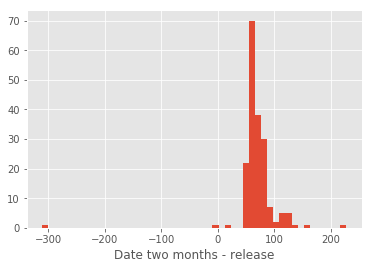

In [527]:
ax = df.release_2months.hist(bins = 50);
ax.set_xlabel('Date two months - release');

Some issues:

In [528]:
df['two_months_deadline'] = pd.DatetimeIndex( df['release_f'] ) + pd.DateOffset(months = 5)
s = ((df.r_2months == 1) & (today > df.two_months_deadline)) & ( (df.release_2months <= 0) | (df.cd2months.isnull()))
df.loc[s,['int', 'id', 'r_2months', 'release_f', 'cd2months', 'two_months_deadline', 'release_2months']].sort_values('id')

,int,id,r_2months,release_f,cd2months,two_months_deadline,release_2months
198,Marcela,10099.0,1.0,2016-12-20,NaT,2017-05-20,NaN
82,Pati,10119.0,1.0,2016-10-17,NaT,2017-03-17,NaN
199,Marcela,10187.0,1.0,2016-12-16,NaT,2017-05-16,NaN
115,Pati,20198.0,1.0,2016-12-28,2016-02-21,2017-05-28,-311.0
69,Marisol,50104.0,1.0,2016-10-24,2016-10-24,2017-03-24,0.0
64,Marisol,50175.0,1.0,2017-01-14,NaT,2017-06-14,NaN


In [529]:
tab  = df.loc[ (today > df.two_months_deadline) | (df.r_2months == 1), 'r_2months'].value_counts()
# print(tab)
rr_2months = [i / sum(list(tab)) for i in tab][0]
# print(rr_2months)

In [530]:
df.loc[np.abs(df.release_2months) > 100,['int', 'id', 'r_2months', 'release_f', 'cd2months', 'two_months_deadline', 'release_2months']].sort_values('id')

,int,id,r_2months,release_f,cd2months,two_months_deadline,release_2months
5,Javi,10087.0,1.0,2016-10-19,2017-02-09,2017-03-19,113.0
190,Susana,10158.0,1.0,2016-11-21,2017-07-07,2017-04-21,228.0
173,Susana,10197.0,1.0,2016-12-26,2017-05-10,2017-05-26,135.0
12,Javi,10233.0,1.0,2017-01-25,2017-05-17,2017-06-25,112.0
74,Marisol,10291.0,1.0,2017-03-22,2017-07-04,2017-08-22,104.0
115,Pati,20198.0,1.0,2016-12-28,2016-02-21,2017-05-28,-311.0
120,Pati,20224.0,1.0,2017-01-16,2017-05-19,2017-06-16,123.0
162,Susana,40152.0,1.0,2016-11-16,2017-03-11,2017-04-16,115.0
216,Marcela,50180.0,1.0,2016-12-07,2017-04-05,2017-05-07,119.0
217,Marcela,50205.0,1.0,2016-12-28,2017-05-04,2017-05-28,127.0


Descriptives:

In [531]:
df.loc[df.r_2months == 1, 'release_2months'].describe()

count    174.000000
mean      68.752874
std       37.103852
min     -311.000000
25%       58.000000
50%       64.000000
75%       78.000000
max      228.000000
Name: release_2months, dtype: float64

## Six Months

In [532]:
#varname = [col for col in df.columns if 'participa ' in col]
#print(varname)

In [533]:
#df = df.rename(columns={varname[0]: 'r_6months'})
df.r_6months.value_counts()
df['r_6months'] = df['r_6months'].str.contains("s|S").astype(float)
df['r_6months'] = df.r_6months.fillna(0)
#df.r_6months.isnull().value_counts()
#df.r_6months.value_counts()

In [ ]:
# date 6months
#varname = [col for col in df.columns if 'fecha entrevista' in col]
#print(varname)

In [ ]:
#df = df.rename(columns={varname[0]: 'd6months'})
df['cd6months'] = [clean_dates(i) for i in df['d6months']]

m = df.cd6months.isnull() & df.d6months.notnull()
m.value_counts()

In [ ]:
# df.loc[m, ['id', 'release_f', 'cd6months', 'd6months']]

In [ ]:
s = (df.r_6months == 1)
#df.loc[s, 'cd6months'].isnull().value_counts()

There is some issues here:

In [ ]:
df.loc[df.id == 50209, 'cd6months'] = pd.to_datetime('2017-07-30')
df = df.assign(release_6months = (df.cd6months - df.release_f).dt.days)

ax = df.release_6months.hist(bins = 20);
ax.set_xlabel('Date six months - release');

In [ ]:
df['six_months_deadline'] = pd.DatetimeIndex( df['release_f'] ) + pd.DateOffset(months = 9)
s = ((df.r_6months == 1) & (today > df.six_months_deadline)) & ( (df.release_6months <= 0) | (df.cd6months.isnull()))
df.loc[s,['int', 'id', 'r_6months', 'release_f', 'd6months', 'cd6months', 'six_months_deadline', 'release_6months']].sort_values('id')

In [ ]:
# df.loc[df.release_6months < -0,['int', 'id', 'r_6months', 'release_f', 'd6months', 'cd6months', 'six_months_deadline', 'release_6months']].sort_values('id')

In [ ]:
df.loc[np.abs(df.release_6months) > 100,['int', 'id', 'r_6months', 'release_f', 'cd6months', 'six_months_deadline', 'release_6months']].sort_values('id')

In [ ]:
tab  = df.loc[(today > df.six_months_deadline)  | (df.r_6months == 1), 'r_6months'].value_counts()
# print(tab)
rr_6months = [i / sum(list(tab)) for i in tab][0]
print(rr_6months)

Some descriptives:

In [ ]:
df.loc[df.r_6months == 1, 'release_6months'].describe()

# Plot of interview days by wave

In [ ]:
ax = df.loc[:, ['release_baseline', 'release_week', 'release_2months', 
                'release_6months']].plot.hist(title='Distribución Día de Entrevista según Ola', alpha=0.6, bins = 200);
ax.set_xlim(-35,365);
ax.legend(['Línea base', 'Primera semana', 'Dos meses', 'Seis meses']);
ax.axvline(7, color = 'gray', linestyle ='--', linewidth=1);
ax.axvline(30.5*2, color = 'gray', linestyle ='--', linewidth=1);
ax.axvline(30.5*6, color = 'gray', linestyle ='--', linewidth=1);
ax.set_xlabel('Días desde la salida');
plt.savefig('plots/dia_entrevista_ola.pdf', dpi = 600)

## Summary rates

In [ ]:
rr = pd.DataFrame( {"rate" : [rr_week, rr_2months, rr_6months]}, 
                       index = ['week' ,'2 months', '6 months'])

rr

In [ ]:
# s = ['id', 'r_week', 'r_2months', 'r_6months', 'interviewer']
# df.loc[:,s].to_csv('/Users/sdaza/Dropbox/Projects/re-entry/10 investigadores/sdaza/reports-github/reports/data/clean_register.csv')